In [2]:
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt

In [3]:
customers = pd.read_csv("D:\ZEOTAP interview\Customers.csv")  
products = pd.read_csv("D:\ZEOTAP interview\Products.csv")  
transactions = pd.read_csv("D:\ZEOTAP interview\Transactions.csv")


In [4]:
transactions_with_region = pd.merge(transactions, customers, on='CustomerID', how='left')
# Add ProductCategory to transactions
transactions_with_category = pd.merge(transactions_with_region, products, on='ProductID', how='left')

In [6]:
# Count the number of products purchased by category for each customer
customer_data = transactions_with_category.groupby(['CustomerID', 'Region', 'Category']).size().reset_index(name='CategoryCount')

In [7]:
customer_features = pd.get_dummies(customer_data, columns=['Region', 'Category'], prefix=['Region', 'Category'])

In [8]:
customer_features = customer_features.groupby('CustomerID').sum().reset_index()

In [9]:
# Step 5: Calculate Similarity
# Drop CustomerID column for similarity calculation
features = customer_features.drop(columns=['CustomerID'])
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

In [10]:
# Compute cosine similarity
similarity_matrix = cosine_similarity(features_scaled)

In [11]:
# Step 6: Generate Top 3 Lookalikes for the First 30 Customers
customer_ids = customer_features['CustomerID']
lookalike_map = {}

In [12]:
for idx, customer_id in enumerate(customer_ids[:30]):  # Limit to the first 20 customers
    # Get similarity scores for the current customer
    scores = list(enumerate(similarity_matrix[idx]))
    # Sort by similarity score (exclude self)
    scores = sorted(scores, key=lambda x: x[1], reverse=True)
    top_3 = [(customer_ids[i], round(score, 3)) for i, score in scores if customer_ids[i] != customer_id][:3]
    lookalike_map[customer_id] = top_3

In [13]:
# Step 7: Save Results to Lookalike.csv
lookalike_df = pd.DataFrame([
    {'CustomerID': cust_id, 'Lookalikes': lookalikes}
    for cust_id, lookalikes in lookalike_map.items()
])
lookalike_df.to_csv('Lookalike.csv', index=False)

print("Lookalike recommendations saved to Lookalike.csv.")

Lookalike recommendations saved to Lookalike.csv.


In [19]:
print(lookalike_df.head())

  CustomerID                                        Lookalikes
0      C0001        [(C0148, 1.0), (C0152, 1.0), (C0174, 1.0)]
1      C0002   [(C0159, 0.99), (C0134, 0.989), (C0133, 0.734)]
2      C0003      [(C0031, 1.0), (C0158, 1.0), (C0129, 0.988)]
3      C0004  [(C0012, 0.989), (C0001, 0.881), (C0148, 0.881)]
4      C0005    [(C0007, 1.0), (C0140, 0.991), (C0095, 0.746)]


In [20]:
similarity_scores = []
for idx in range(len(customer_ids)):
    scores = [similarity_matrix[idx][i] for i in range(len(customer_ids)) if i != idx]
    similarity_scores.extend(scores)

In [21]:
mean_score = np.mean(similarity_scores)
std_dev_score = np.std(similarity_scores)
print(f"Mean similarity score: {mean_score:.3f}")
print(f"Standard deviation of similarity scores: {std_dev_score:.3f}")

Mean similarity score: -0.005
Standard deviation of similarity scores: 0.370


In [ ]:
#Mean being close to zero: Similarity scores are evenly distributed around zero, indicating that many pairs are dissimilar.
#High standard deviation: There's a large variance in similarity scores, meaning some customers are highly similar, while others are very dissimilar.

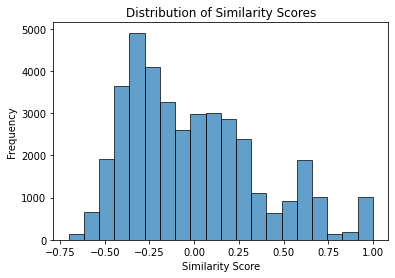

In [23]:
# histogram  scores
plt.hist(similarity_scores, bins=20, edgecolor='k', alpha=0.7)
plt.title('Distribution of Similarity Scores')
plt.xlabel('Similarity Score')
plt.ylabel('Frequency')
plt.show()


In [ ]:
#A wide spread suggests variability in the scores, which can be good if the variability aligns with meaningful customer distinctions.